# ch1 简单车道线检测


## p1:color selection

1.通过阈值过滤

2.区域选择


## np.meshgrid(x, y)用法

[[0 1 2]
 [0 1 2]]
[[0 0 0]
 [1 1 1]]


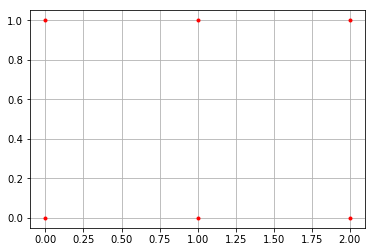

In [29]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([0, 1, 2])
y = np.array([0, 1])

X, Y = np.meshgrid(x, y)
print(X)
print(Y)


plt.plot(X, Y,
         color='red',  # 全部点设置为红色
         marker='.',  # 点的形状为圆点
         linestyle='')  # 线型为空，也即点与点之间不用线连接
plt.grid(True)
plt.show()


(500, 1000)
(500, 1000)


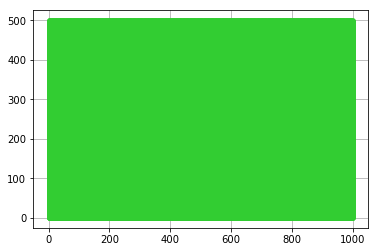

In [30]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,1000,1000)
#print(x)
y = np.linspace(0,500,500)

X,Y = np.meshgrid(x, y)
print(X.shape)
print(Y.shape)
plt.plot(X, Y,
         color='limegreen',  # 设置颜色为limegreen
         marker='.',  # 设置点类型为圆点
         linestyle='')  # 设置线型为空，也即没有线连接点
plt.grid(True)
plt.show()


## np.polyfit()用法

# p2. 边缘检测

### cv2.GaussianBlur()用法

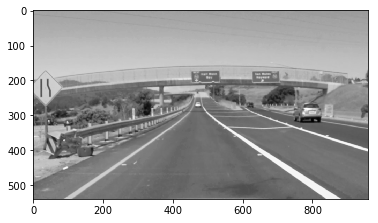

In [31]:
#doing all the relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in the image and convert to grayscale
image = mpimg.imread('./images/exit-ramp.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)
plt.imshow(blur_gray, cmap='Greys_r')
plt.show()

### cv2.Canny()边缘检测

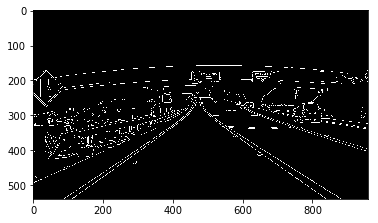

In [32]:
# Define parameters for Canny and run it
# NOTE: if you try running this code you might want to change these!
low_threshold = 80
high_threshold = low_threshold*2
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Display the image
plt.imshow(edges, cmap='Greys_r')
plt.show()

### cv2.fillPoly() 填充多边形

cv2.fillPoly()函数可以用来填充任意形状的图型.可以用来绘制多边形,

工作中也经常使用非常多个边来近似的画一条曲线.

cv2.fillPoly()函数可以一次填充多个图型.

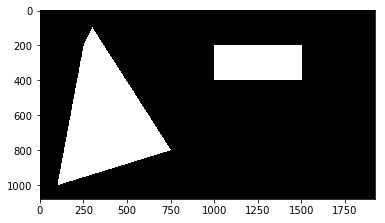

In [33]:
img = np.zeros((1080, 1920, 3), np.uint8)
area1 = np.array([[250, 200], [300, 100], [750, 800], [100, 1000]])
area2 = np.array([[1000, 200], [1500, 200], [1500, 400], [1000, 400]])

cv2.fillPoly(img, [area1, area2], (255, 255, 255))

plt.imshow(img)
plt.show()

### cv2.bitwise_and() 与操作

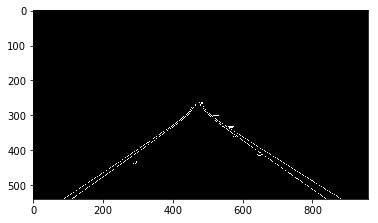

In [34]:
# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = (255,)* 3


left_bottom = [100, 550]
right_bottom = [850, 550]
apex = [450, 300]

# This time we are defining a four sided polygon to mask
imshape = image.shape
#vertices = np.array([[(50,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
vertices = np.array([[(80,imshape[0]),(480, 260),(500, 260), (900,imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)
plt.imshow(masked_edges, cmap='Greys_r')
plt.show()

# p3. 霍夫变换

cv2.HoughLinesP():霍夫变换

cv2.line()：画线

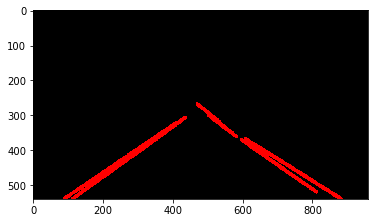

In [35]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 5     # minimum number of votes (intersections in Hough grid cell)
min_line_length =60 #minimum number of pixels making up a line
max_line_gap = 10    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 
plt.imshow(line_image)
plt.show()

### cv2.addWeighted()

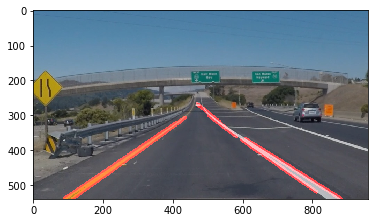

In [36]:
# Draw the lines on the edge image
lines_edges = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
plt.imshow(lines_edges)
plt.show()

# ch2 高级视觉

the first step is to sense or perceive the world.

the second step is to decide what to do based on that perception.

and the third step is to perform an action to carry out that decision.

radar and lidar see the world in 3D



从真实世界三维坐标到二维图像坐标的变换矩阵，叫做相机矩阵；

失真的类型：

1.radial distortion:真实相机用弯曲镜头来成像，光线在镜头边缘处经常弯曲，称为径向失真；

2.tangential distortion:切向失真，镜头未完全平行于成像面时，使得图像看起来倾斜；





![avatar](./images/distortion_radial.png)



失真系数和矫正：

1.radial distortion系数有三个：k1,k2 and k3. 可以使用矫正公式校正径向扭曲了图像；


Distortion_coefficients = (k1 k2 p1 p2 k3)一般用五个参数可以消除失真；

![avatar](./images/distortion_radial2.png)

## P1 畸变矫正

用到的opencv函数

1.得到灰度图

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

2.Finding chessboard corners (for an 8x6 board):

ret, corners = cv2.findChessboardCorners(gray, (8,6), None)


3.Drawing detected corners on an image:

img = cv2.drawChessboardCorners(img, (8,6), corners, ret)


4.标定相机Camera calibration

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

objpoints:对象点坐标，3D points in real world space

imgpoints:图像点坐标，2D points in image plane


5.图像矫正：Undistorting a test image:

dst = cv2.undistort(img, mtx, dist, None, mtx)




### sample1 角点检测


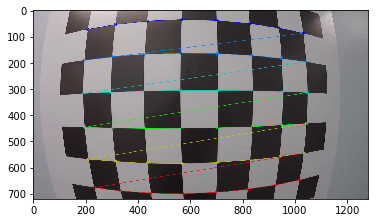

In [55]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points
nx = 8#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# Make a list of calibration images
fname = './images/calibration_test.png'
img = cv2.imread(fname)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)
    plt.show()

### sample2 标定相机，畸变矫正

In [77]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open( "lesson5/wide_dist_pickle.p", "rb" ) )
objpoints = dist_pickle["objpoints"]  #3D points in real world space,对象点位置
imgpoints = dist_pickle["imgpoints"]  #2D，角点在图像的实际坐标

print(len(objpoints),objpoints[0].shape)  #35张图，每张图48个点
print(len(imgpoints),imgpoints[0].shape)  #35张图，每张图48个点，每个点，x,y坐标

35 (48, 3)
35 (48, 1, 2)


In [78]:
# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    img_size = (img.shape[1],img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_size,None,None)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    #undist = np.copy(img)  # Delete this line
    return undist

# Read in an image
img = cv2.imread('lesson5/test_image.png')
print(img.shape)
undistorted = cal_undistort(img, objpoints, imgpoints)



(960, 1280, 3)


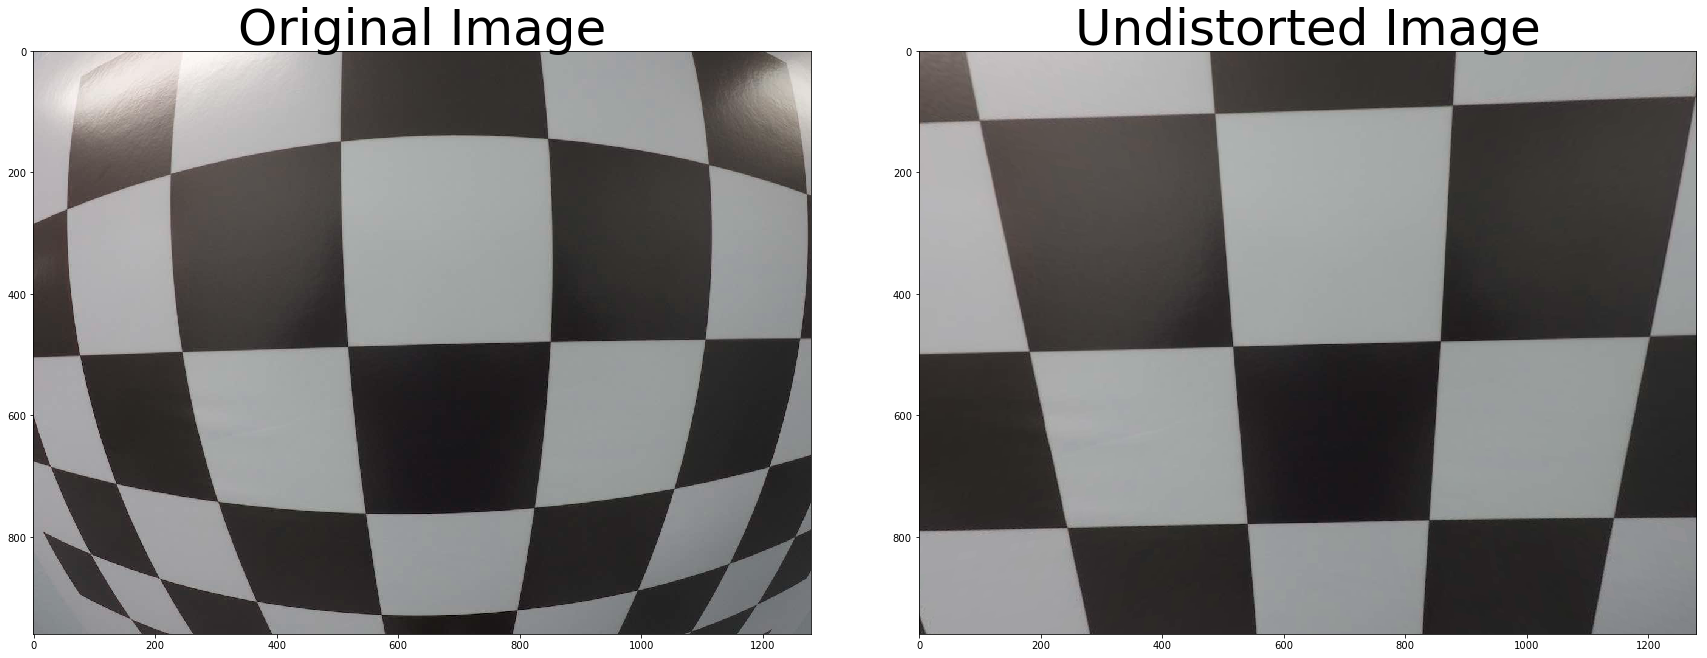

In [79]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## P2 Perspective,视角转化